# non-Sterile interaction
#### This version is tested with Anaconda Python 3.7.3,  Numpy 1.16.2, Numba 0.43.1 and Matplotlib 3.0.3
#### There might be problem with lower version of numba

### loading the library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

### Reading the data files

In [2]:
#=================================== Energy and cross section data:

# Unit is GeV and Km

x = np.loadtxt("./ExperimentalData/XCC.dat").transpose()

# In this file:
    # 10**x[0] is energy
    # x[1] is charged current quasi-elastic neutrino interaction 
    # x[4] is charged current quasi-elastic anti-neutrino interaction 

energy_cross_section = 10**x[0]
quasi_elastic_nu_cross = x[1]
quasi_elastic_anu_cross = x[4]

cross_section = [quasi_elastic_nu_cross, energy_cross_section]
anu_cross_section = [quasi_elastic_anu_cross, energy_cross_section]


#================================ Reading flux and their associated energy:

[eflux_nu, flux_nu] = np.loadtxt("./ExperimentalData/flux_neutrio_muon_MiniBooNE.csv",delimiter=",").transpose()
[eflux_anu, flux_anu] = np.loadtxt("./ExperimentalData/flux_antineutrio_muon_MiniBooNE.csv",delimiter=",").transpose()

nu_flux = [flux_nu, eflux_nu]
anu_flux = [flux_anu, eflux_anu] 


#================================ Experimental data of MiniBoone:

nexp_nu_mini = np.array([138.214,74.732175,72.1753,33.96915,4.0178625,30.681875,1.753245,7.01298,16.94806])
error_nu_mini = np.array([42.3699,24.5454,26.5909,17.3133,21.733,18.2629625,20.381475,16.43667,19.285723])

nexp_anu_mini = np.array([31.8506,16.4367,6.42857,11.3961,14.245125,5.1136375,-0.438312,-6.136365,-2.33766])
error_anu_mini = np.array([14.02595,9.20454,8.766225,7.12258125,8.9488625,7.67046875,7.232145,5.9172075,6.42857])

bins = np.array([0.200,0.300,0.375,0.475,0.550,0.675,0.800,0.950,1.100,1.300])





# functions

## paper arXiv:0806.1449 page 49 and 50

In [3]:
def neutrino_flux(energy,flux, eflux):
    """
    This function calculate the flux for a given energy
    
    flux ...
    eflux ...
    """
    for i in np.arange(len(flux)-1):
        if (energy >= eflux[i] and energy < eflux[i+1]):
            rho = flux[i]
            break
            
    if(energy < eflux[0]):
        rho = 0
    
    if ( energy > eflux[-1]):
        rho = 0

    return rho*1.0

## from globes

In [4]:
def cross_section_ccqe_nu(energy ,cross_section, ecross_section):
    """
    ....
    """
    for i in np.arange(len(cross_section)-1):
        if (energy >= ecross_section[i] and energy < ecross_section[i+1]):
            cross = cross_section[i] + ((cross_section[i+1]-cross_section[i])/(ecross_section[i+1]-ecross_section[i])) \
            * (energy - ecross_section[i])
            break
            
    if(energy < ecross_section[0]):
        cross = 0
    
    if ( energy > ecross_section[-1]):
        cross = cross_section[-1]
    

    return cross*1.0
    

In [5]:
def delta_dirac(a,b):
    if (a == b):
        return 1
    elif (a != b):
        return 0
    else:
        return np.nan

# fundamentals of neutrino physics in astro physics Giunti

page 252

In [6]:
def Oscillation_Probability_4nu(alpha, beta, dm2, t14,t24, t34, baseline, energy):
    """
        Enter t14 t24 t34 in degrees
        
        for alpha and beta variable enter:
        0 for electorn neutrio
        1 for muon neutrio
        2 for tau neutrio
        3 for sterile neutrio

        baseline in meter and energy in MeV or baseline in kilometer and energy in GeV
    """  
    
    t14 = np.deg2rad(t14)
    t24 = np.deg2rad(t24)
    t34 = np.deg2rad(t34)
        
    c14 = np.cos(t14)
    s14 = np.sin(t14)

    c24 = np.cos(t24)
    s24 = np.sin(t24)

    c34 = np.cos(t34)
    s34 = np.sin(t34) 
    
    UT = [s14, c24*s24, s34 * c24**2, c34 *  c24**2]
    
    uta = UT[alpha]
    
    utb = UT[beta]
    
    P2 = uta *  utb * (delta_dirac(alpha, beta) - uta *  utb)
    
    return delta_dirac(alpha, beta) - 4 * (np.sin((1.27*dm2 * baseline)/energy)**2)* P2    

# $N_i(\theta) = n_f \int dE_{\nu} P_{ee}(E_{\nu};\theta)\sigma(E_{\nu})R_i(E_{\nu}) $

from Toma Schwetz persentation, Neutrino data analysis  (Stockholm U)
here we set R = 1

...

with assumption of Gaussianinty for 

In [1]:
def N_th_per_bin(energies, theta14 , theta24, dm2,L, cross_section,flux):
    """
    Energies is a list with three memebers:
        Energies = [E_min, E_max, num]
        
    ROTATION ANGLES

        Theta24 is in degree
        Theta14 is setted to 90.0
        Theta34 is setted to 0.0

    
    flux is a list with 2 members:
        flux = [flux_nu, eflux_nu]
        OR
        flux = [flux_anu, eflux_anu]     
        
    cross_section is a list with two members
        cross_section = [quasi_elastic_nu_cross, energy_cross_section]
        
    sin2th2, dm2,L,E
    """
    dE = (energies[1]- energies[0])/energies[2]
    energy_array = np.linspace(energies[0], energies[1], energies[2])
    flux_array = []
    cross_section_array = []
    p = []
    for e in energy_array:
        flux_array.append(neutrino_flux(e,flux[0], flux[1]))
        cross_section_array.append(cross_section_ccqe_nu(e ,cross_section[0], cross_section[1]))
        p.append(Oscillation_Probability_4nu(1, 0, dm2 , theta14 , theta24 , 0.0 , L, e))
    
    p = np.array(p)
    cross_section_array = np.array(cross_section_array) 
    flux_array = np.array(flux_array)
    
    return (p*cross_section_array*flux_array*dE).sum()



## 1805.12028 page 8
cross section times flux times P=1 



In [8]:
"""
RUN FOR Nf ONLY
DON'T TRY IT AT HOME
"""
def N_th_per_bin_nf(energies, theta14 , theta24, dm2,L, cross_section,flux, run_status = False):
    """
    Energies is a list with three memebers:
        Energies = [E_min, E_max, num]
        
    ROTATION ANGLES

        Theta24 is in degree
        Theta14 is setted to 90.0
        Theta34 is setted to 0.0

    
    flux is a list with 2 members:
        flux = [flux_nu, eflux_nu]
        OR
        flux = [flux_anu, eflux_anu]     
        
    cross_section is a list with two members
        cross_section = [quasi_elastic_nu_cross, energy_cross_section]
        
    sin2th2, dm2,L,E
    """
    if (run_status):
        dE = (energies[1]- energies[0])/energies[2]
        energy_array = np.linspace(energies[0], energies[1], energies[2])
        flux_array = []
        cross_section_array = []
        p = []
        for e in energy_array:
            flux_array.append(neutrino_flux(e,flux[0], flux[1]))
            cross_section_array.append(cross_section_ccqe_nu(e ,cross_section[0], cross_section[1]))
            p.append(1.0)

        p = np.array(p)
        cross_section_array = np.array(cross_section_array) 
        flux_array = np.array(flux_array)

        return sum(p*cross_section_array*flux_array)*dE

    else:
        pass





## 1805.12028 page 8


in figure 8 #event of $\nu_\mu$ is presented
## to compute $n_f = \frac{n_{exp}}{above{\ }mentioned{\ }integral}$  = 

In [9]:
energies = [0.1, 1.5, 100]
theta24 = 30.0
theta14 = 90.0
dm2 = 1.0
L = 0.5
flux = [flux_nu, eflux_nu]
cross_section = [quasi_elastic_nu_cross, energy_cross_section]

nf_MiniBoone = (114020.130254588)/N_th_per_bin_nf(energies, theta14, theta24, dm2,L, cross_section,flux,True)


In [10]:
n_th_old = []
for i in range(len(bins)-1):
    energies = [bins[i], bins[i+1], 100]
    n_th_old.append(nf_MiniBoone * N_th_per_bin(energies, theta14, theta24, dm2,L, cross_section,flux))
n_th_old = np.array(n_th_old)

n_th_old 

array([1183.13881414, 3641.76117169, 6748.33613883, 5448.47773349,
       8406.02128082, 6664.47320538, 5892.34942811, 3697.98836597,
       2933.01517834])

# $\chi^2 = \sum_i \Big(\frac{N_i^{th}(i) - N_i^{exp}}{\sigma_i}\Big)^2$

In [11]:
def chi2(nf, theta14, theta24, dm2,L, cross_section, bins, n_exp, error,flux):
    '''
        NORMATIZATION FACTOR HAS TO BE IN THE INPUT
    '''
    n_th = []
    for i in range(len(bins)-1):
        energies = [bins[i], bins[i+1], 100]
        n_th.append(nf * N_th_per_bin(energies, theta14, theta24, dm2,L, cross_section,flux))
    n_th = np.array(n_th)
    return sum(((n_th - n_exp)/error)*((n_th - n_exp)/error))
    
                       

# Do this with gradiant decent 

for pull methods 

In [12]:
def chi2_min_finder(CHI2_MAT, DM2, arc_theta_24):
    rows_c = 0
    cols_c = 0
    chi2_min = CHI2_MAT.min()
    for rows in CHI2_MAT:
        for cols in rows:
            if (cols == chi2_min ):
                return arc_theta_24[rows_c], DM2[cols_c]
            else:
                if (cols_c + 1 == len(rows)):
                    cols_c = 0
                else:
                    cols_c += 1
        rows_c += 1

# Changing the parameters

## This section is changing $\theta_{14}$ and $\theta_{24}$

In [13]:
energies = [0.1, 1.5, 100]
num = 50
a = np.linspace(-2,2,num)
DM2 = 10.0**a
power = np.linspace(-4,0,num)
sin2_theta_14 = 10.0**power
sin2_theta_24 = 10.0**power
L = 0.5
parameter_mat = "theta_14_theta24"
nu_file_name = "./Output/non_interactive/nue_"+parameter_mat+"_"+str(num)+"_CHI2_MAT.dat"
anu_file_name = "./Output/non_interactive/anue_"+parameter_mat+"_"+str(num)+"_CHI2_MAT.dat"

##  $\nu$

In [14]:
f = open(nu_file_name,"w")
count = 1
for sin2theta24 in sin2_theta_24:
    theta24 = np.rad2deg(np.arcsin(np.sqrt(sin2theta24)))/2.0
    for sin2theta14 in sin2_theta_14:
        theta14 = np.rad2deg(np.arcsin(np.sqrt(sin2theta14)))/2.0
        chi2_value = chi2(nf_MiniBoone, theta14, theta24, dm2,L, cross_section, bins, nexp_nu_mini, error_nu_mini,nu_flux)
        f.write(str(chi2_value)+"\t")
        if (count == len(sin2_theta_14)):
            f.write("\n")
            count = 1
        else:
            count = count + 1
f.close() 

##  $\bar{\nu}$

In [15]:
f = open(anu_file_name,"w")
count = 1
for sin2theta24 in sin2_theta_24:
    theta24 = np.rad2deg(np.arcsin(np.sqrt(sin2theta24)))/2.0
    for sin2theta14 in sin2_theta_14:
        theta14 = np.rad2deg(np.arcsin(np.sqrt(sin2theta14)))/2.0
        chi2_value = chi2(nf_MiniBoone, theta14, theta24, dm2,L, anu_cross_section, bins, nexp_anu_mini, error_anu_mini,anu_flux)
        f.write(str(chi2_value)+"\t")
        if (count == len(sin2_theta_14)):
            f.write("\n")
            count = 1
        else:
            count = count + 1
f.close()



In [16]:
CHI2_MAT_nu = np.loadtxt(nu_file_name)
CHI2_MAT_anu = np.loadtxt(anu_file_name)
chi_kol = CHI2_MAT_nu  + CHI2_MAT_anu

In [17]:
x_min, y_min = chi2_min_finder(chi_kol,  sin2_theta_14, sin2_theta_24)
print(x_min,y_min)

0.015998587196060572 0.6866488450042998


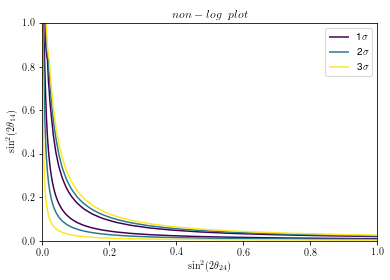

In [37]:
fig, ax = plt.subplots()

y , x = np.meshgrid(sin2_theta_14, sin2_theta_24)
CS = ax.contour(x, y ,chi_kol - chi_kol.min() ,levels =  [2.3,6.18,11.83]) 
#plt.clabel(CS, inline=1, fontsize=10)   # this is countor label
labels = ['1$\sigma$', '2$\sigma$','3$\sigma$']
for i in range(len(labels)):
    ax.collections[i].set_label(labels[i])

#ax.set_xticklabels([0, .1,.2,.3,.4,.5,.6,.7,.8,.9,.10])
#ax.scatter(x_min,y_min,marker="o",s=100,c="k")

ax.set_xlabel(r"$\sin^2(2\theta_{24})$")
ax.set_ylabel(r"$\sin^2(2\theta_{14})$")

#plt.legend(loc=3);ax.set_yscale('log');ax.set_xscale('log');ax.set_title(r"$log-log~~plot$");plt.savefig("./Output/non_interactive/"+parameter_mat+"_"+str(num)+"_log.pdf")

plt.legend(loc=0);ax.set_title(r"$non-log~~plot$");plt.savefig("./Output/non_interactive/"+parameter_mat+"_"+str(num)+"_.pdf")







## This section is changing $\theta_{14}$ and $M_{Z'}$

In [38]:
energies = [0.1, 1.5, 100]
num = 40
a = np.linspace(-2,2,num)
DM2 = 10.0**a
power = np.linspace(-4,0,num)
sin2_theta_14 = 10.0**power
sin2_theta_24 = 9.3
L = 0.5

parameter_mat = "theta_14_MZ"
nu_file_name = "./Output/nue"+parameter_mat+str(num)+"CHI2_MAT.dat"
anu_file_name = "./Output/anue"+parameter_mat+str(num)+"CHI2_MAT.dat"

In [39]:
f = open(nu_file_name,"w")
count = 1
for sin2theta14 in sin2_theta_14:
    theta14 = np.rad2deg(np.arcsin(np.sqrt(sin2theta14)))/2.0
    for dm2 in DM2:
        chi2_value = chi2(nf_MiniBoone, theta14, theta24, dm2,L, anu_cross_section, bins, nexp_anu_mini, error_anu_mini,anu_flux)
        f.write(str(chi2_value)+"\t")
        if (count == len(DM2)):
            f.write("\n")
            count = 1
        else:
            count = count + 1
f.close()           

In [40]:
f = open(anu_file_name,"w")
count = 1
for sin2theta14 in sin2_theta_14:
    theta14 = np.rad2deg(np.arcsin(np.sqrt(sin2theta14)))/2.0
    for dm2 in DM2:
        chi2_value = chi2(nf_MiniBoone, theta14, theta24, dm2,L, anu_cross_section, bins, nexp_anu_mini, error_anu_mini,anu_flux)
        f.write(str(chi2_value)+"\t")
        if (count == len(DM2)):
            f.write("\n")
            count = 1
        else:
            count = count + 1
f.close()     

In [74]:
CHI2_MAT_nu = np.loadtxt(nu_file_name)
CHI2_MAT_anu = np.loadtxt(anu_file_name)
chi_kol = CHI2_MAT_nu  + CHI2_MAT_anu

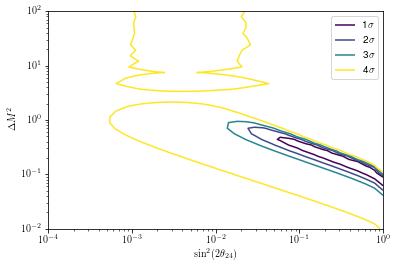

In [76]:
fig, ax = plt.subplots()

y , x = np.meshgrid(DM2, sin2_theta_14)
CS = ax.contour(x, y ,chi_kol - chi_kol.min() ,levels =  [3.3,7.18,11.23,20.9]) 
#plt.clabel(CS, inline=1, fontsize=10)   # this is countor label
labels = ['1$\sigma$', '2$\sigma$','3$\sigma$','4$\sigma$']
for i in range(len(labels)):
    ax.collections[i].set_label(labels[i])
    
#ax.set_xticklabels([0, .1,.2,.3,.4,.5,.6,.7,.8,.9,.10])
#ax.scatter(x_min,y_min,marker="o",s=100,c="k")

plt.legend(loc=0)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r"$\sin^2(2\theta_{24})$")
ax.set_ylabel("$\Delta M^2$")
plt.savefig("./Output/non_interactive/"+parameter_mat+"_"+str(num)+"_.pdf")